In [852]:
from velocity_plot import velocity_plot as vpl
from sampling import *
from colormap import *

import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform

from turtle import color
import matplotlib as mpl
import matplotlib.pyplot as plt

import multiprocessing as mp
import random
import os

# Yet not Required:
#!pip install dtw-python
#!pip install fastcluster
# yet unused
from fastcluster import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster

In [3]:
import numpy as np
help(np.divide)

Help on ufunc object:

true_divide = class ufunc(builtins.object)
 |  Functions that operate element by element on whole arrays.
 |  
 |  To see the documentation for a specific ufunc, use `info`.  For
 |  example, ``np.info(np.sin)``.  Because ufuncs are written in C
 |  (for speed) and linked into Python with NumPy's ufunc facility,
 |  Python's help() function finds this page whenever help() is called
 |  on a ufunc.
 |  
 |  A detailed explanation of ufuncs can be found in the docs for :ref:`ufuncs`.
 |  
 |  **Calling ufuncs:** ``op(*x[, out], where=True, **kwargs)``
 |  
 |  Apply `op` to the arguments `*x` elementwise, broadcasting the arguments.
 |  
 |  The broadcasting rules are:
 |  
 |  * Dimensions of length 1 may be prepended to either array.
 |  * Arrays may be repeated along dimensions of length 1.
 |  
 |  Parameters
 |  ----------
 |  *x : array_like
 |      Input arrays.
 |  out : ndarray, None, or tuple of ndarray and None, optional
 |      Alternate array object(s)

In [782]:
def corr_coeff(ematrix, vmatrix, i):
    '''
    Calculate the correlation between the predict velocity (velocity_matrix[:,i])
    and the difference between a cell and every other (cell_matrix - cell_matrix[:, i])
    '''
    # ematrix = cell_matrix
    # vmatrix = velocity_matrix
    ematrix = ematrix.T
    vmatrix = vmatrix.T
    ematrix = ematrix - ematrix[i, :]
    vmatrix = vmatrix[i, :][None, :]
    ematrix_m = ematrix - ematrix.mean(1)[:, None]
    vmatrix_m = vmatrix - vmatrix.mean(1)[:, None]

    # Sum of squares across rows
    ematrix_ss = (ematrix_m**2).sum(1)
    vmatrix_ss = (vmatrix_m**2).sum(1)
    cor = np.dot(ematrix_m, vmatrix_m.T) / \
        np.sqrt(np.dot(ematrix_ss[:, None], vmatrix_ss[None]))
    return cor.T


def velocity_correlation(cell_matrix, velocity_matrix):
    """Calculate the correlation between the predict velocity (velocity_matrix[:,i])
    and the difference between a cell and every other (cell_matrix - cell_matrix[:, i])

    Arguments
    ---------
    cell_matrix: np.ndarray (ngenes, ncells)
        gene expression matrix
    velocity_matrix: np.ndarray (ngenes, ncells)
    Return
    ---------
    c_matrix: np.ndarray (ncells, ncells)
    """
    c_matrix = np.zeros((cell_matrix.shape[1], velocity_matrix.shape[1]))
    for i in range(cell_matrix.shape[1]):
        c_matrix[i, :] = corr_coeff(cell_matrix, velocity_matrix, i)[0, :]
    
    
    np.fill_diagonal(c_matrix, 0)
    return c_matrix


def velocity_projection(cell_matrix, velocity_matrix, embedding, knn_embedding):
    '''
    cell_matrix: np.ndarray (ngenes, ncells)
        gene expression matrix
    velocity_matrix: np.ndarray (ngenes, ncells)
    '''
    # cell_matrix = np_s0[:,sampling_ixs]
    # velocity_matrix = np_dMatrix[:,sampling_ixs]
    
    sigma_corr = 0.05
    cell_matrix[np.isnan(cell_matrix)] = 0
    velocity_matrix[np.isnan(velocity_matrix)] = 0
    corrcoef = velocity_correlation(cell_matrix, velocity_matrix)
    probability_matrix = np.exp(corrcoef / sigma_corr)*knn_embedding.A
    probability_matrix /= probability_matrix.sum(1)[:, None]
    unitary_vectors = embedding.T[:, None, :] - embedding.T[:, :, None]
    with np.errstate(divide='ignore', invalid='ignore'):
        unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)
        np.fill_diagonal(unitary_vectors[0, ...], 0)
        np.fill_diagonal(unitary_vectors[1, ...], 0)
    velocity_embedding = (probability_matrix * unitary_vectors).sum(2)
    velocity_embedding -= (knn_embedding.A * unitary_vectors).sum(2) / \
        knn_embedding.sum(1).A.T  # embedding_knn.A *
    velocity_embedding = velocity_embedding.T
    
    return velocity_embedding, probability_matrix


def data_reshape(load_cellDancer):
    '''
    load detail file
    return expression matrix and velocity (ngenes, ncells)
    '''
    psc = 1
    gene_names = load_cellDancer['gene_name'].drop_duplicates().to_list()
    cell_number = load_cellDancer[load_cellDancer['gene_name']==gene_names[0]].shape[0]
    load_cellDancer['index'] = np.tile(range(cell_number),len(gene_names))
    s0_reshape = load_cellDancer.pivot(
        index='gene_name', values='s0', columns='index')
    s1_reshape = load_cellDancer.pivot(
        index='gene_name', values='s1', columns='index')
    dMatrix = s1_reshape-s0_reshape
    np_s0_reshape = np.array(s0_reshape)
    np_dMatrix = np.array(dMatrix)
    np_dMatrix2 = np.sqrt(np.abs(np_dMatrix) + psc) * \
        np.sign(np_dMatrix)  # (2159, 18140)
    return(np_s0_reshape, np_dMatrix2)


In [784]:
load_cellDancer = pd.read_csv('/Users/pengzhizhang/Documents/test_data/detail_e307.csv', index_col=[0])
load_cellDancer = load_cellDancer.rename_axis('cell_index').sort_values(by = ['gene_name', 'cell_index'], ascending = [True, True])
np_s0, np_dMatrix = data_reshape(load_cellDancer)
np_dMatrix_all=np_dMatrix
np_s0_all=np_s0

In [785]:
raw_data_path = "/Users/pengzhizhang/Documents/test_data/denGyr_full.csv"
load_raw_data = pd.read_csv(raw_data_path, names=[
                            'gene_list', 'u0', 's0', "clusters", 'cellID', 'embedding1', 'embedding2'])

detail_result_path = '/Users/pengzhizhang/Documents/test_data'
output_path = '/Users/pengzhizhang/Documents/test_data'

In [787]:
gene_choice=list(set(load_cellDancer.gene_name))
n_neighbors=100
add_amt_gene=10
data_df = load_raw_data[['gene_list', 'u0', 's0', 'cellID',
        'embedding1', 'embedding2']][load_raw_data.gene_list.isin(gene_choice)]

random.seed(10)
embedding_downsampling, sampling_ixs, knn_embedding \
= downsampling_embedding(data_df,
                        para='neighbors',
                        target_amount=0,
                        step_i=60,
                        step_j=60,
                        n_neighbors=n_neighbors)

neighbors


In [788]:
embedding_df = data_df.drop_duplicates(subset='cellID')[['embedding1', 'embedding2']]
embedding = embedding_df.to_numpy()

velocity_embedding, probability_matrix = velocity_projection(
    np_s0_all[:, sampling_ixs], 
    np_dMatrix_all[:, sampling_ixs], 
    embedding[sampling_ixs, :], 
    knn_embedding)

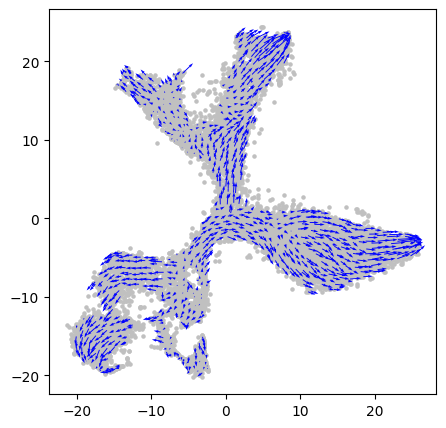

In [789]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(embedding[:, 0],embedding[:, 1], c="Silver", s=5, alpha=1)
plt.quiver(embedding[sampling_ixs, 0],embedding[sampling_ixs, 1],
          velocity_embedding[:,0], velocity_embedding[:,1], color='Blue')
plt.show()

In [790]:
def gaussian_kernel(X, mu=0, sigma=1):
    return np.exp(-(X - mu)**2 / (2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

In [791]:
def compute_transition_matrix(prob_matrix, embedding, knn_embedding, mix_ratio=0.2):
    
    # sigma_D is set to the average distance between the closest neighbours
    X = pairwise_distances(embedding)
    
    X_temp = X + np.identity(X.shape[0])*X.max()
    near_dist = X_temp.min(axis=0)
    sigma_D = near_dist.mean()
    sigma_W = 0.5 * sigma_D
    W = gaussian_kernel(X, sigma=sigma_W)
    W /= W.sum(1)[:,None]
    
    D = prob_matrix * gaussian_kernel(X, sigma=sigma_D)
    np.fill_diagonal(D, D.max(1))
    D /= D.sum(1)[:,None]
    
    T = W*mix_ratio + D*(1-mix_ratio)
    T /= T.sum(1)[:,None]
    return T, W, D

In [673]:
%%script echo skipping
embedding_lookup = load_raw_data.loc[embedding_downsampling.index]
embedding_lookup = embedding_lookup.drop_duplicates(subset='cellID')
embedding_lookup = embedding_lookup.reset_index(drop=True)

def index(coordinate,  tol=0.5):
    '''
    Find the nearby cells to a given coordinate.
    
    Parameters
    ----------
    coordinate
        a tuple, coordinate of a point in the embedding
    tol
        how close should the cells be searched
    Return
    ------
    a list of cells (indexed from 0)
    '''
    em1,em2 = coordinate
    selected = embedding_lookup[((embedding_lookup.embedding1<em1+tol) 
                                 & (embedding_lookup.embedding1>em1-tol) 
                                 & (embedding_lookup.embedding2<em2+tol) 
                                 & (embedding_lookup.embedding2>em2-tol))]
    return selected.index.to_list()

In [792]:
%%script echo skipping
transition_matrix, W, D = compute_transition_matrix(probability_matrix, 
                                              embedding_downsampling.to_numpy(), 
                                              knn_embedding, 
                                              0.2)

skipping


In [793]:
def embedding_normalization(embedding, mode="max"):
    '''
    Normalize by the maximum absolute value.
    
    Parameters
    ----------
    embedding: 2D numpy array (n_cells, 2)
    
    mode: 'normal', 'maxabs'
    
    (???)
    Note in this program, it is pretty safe to do maxabs normalization
    since the data are free of extreme outliers.
     
    '''
    from sklearn.preprocessing import normalize
    from sklearn.preprocessing import MaxAbsScaler

    if mode in ['norm', 'normal']:
        em = normalize(embedding, axis = 0)
    elif mode in ['max', 'maximum', 'maxabs']:
        transformer = MaxAbsScaler().fit(embedding)
        em = transformer.transform(embedding)

    return em

cell_embedding = embedding_normalization(embedding_downsampling.to_numpy())
velocity = embedding_normalization(velocity_embedding)

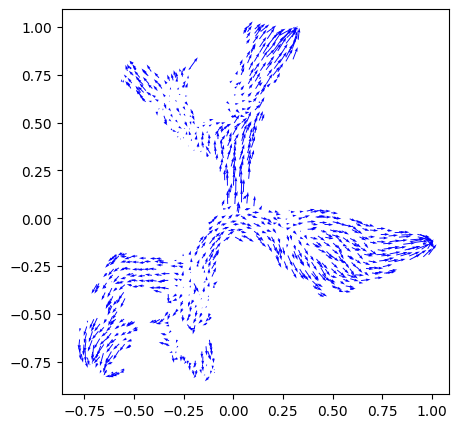

In [794]:
#sanity check
fig, ax = plt.subplots(figsize=(5, 5))
plt.quiver(cell_embedding[:,0],cell_embedding[:,1],velocity[:,0],velocity[:,1], color='Blue')
plt.show()

In [795]:
# move with closest neighbours
def diffusion(cell_embedding, velocity, init, dt, timestep, n_neighbors, eps = 1e-3):
      
    '''
    Simulation of diffusion of cells in the velocity field
    - velocity of nearest cells (v_net) are used to calculate 
        the velocity of a point in the embedding space
    - init is the initial cell or initial position
    - dt is time step
    - timestep is total number of time steps
    - eps is the criterion to stop a trajectory before timestep (v_net < eps)
    - keep track of the density of the nearest grid.
    '''
    
    # normalize the velocity to make it [-100,100]
    velocity /= max(velocity.max(), -velocity.min())
    nn = NearestNeighbors(n_neighbors=n_neighbors, radius=1, n_jobs=8)
    nn.fit(cell_embedding)
    
    dist, ix1 =  nn.kneighbors(cell_embedding, 10)
    ave_nb_dist = dist.mean(0)
    ave_10_nb_dist = dist.mean(0)[-1]
    
   # This function is slow
   # Need to put position on the mesh grid --> vnet
    def compute_vnet(position):
        nbrs = nn.radius_neighbors(position[None,:], radius=ave_10_nb_dist, return_distance=False)
        if(nbrs[0].any() == 0):
            print("yikes, no neighbour")
            return np.array([0,0])
        return np.mean(np.array([velocity[i] for i in nbrs[0]]), axis = 0)
        
    x0 = cell_embedding[init]
    vnet = velocity[init]
    trajectory = [x0]
    for i in range(timestep):
        x = x0 + vnet*dt
        vnet = compute_vnet(x)
        trajectory.append(x)
        if np.linalg.norm(vnet) < eps:
            print("velocity at ", x, "is too small")
            print("trajectory stopped at time step: ", i)
            break
        #print(i, x, vnet)
        x0 = x

    return trajectory

In [796]:
%%script echo skipping

for traj_num in (0, 334, 178, 582, 250):
    traj = diffusion(cell_embedding,velocity_embedding, traj_num, 0.001, 1000, 100)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.scatter(cell_embedding[:,0],cell_embedding[:,1], c='grey', alpha = 0.3)
    plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], s=20, c=range(len(traj)))
    ax.set_aspect('equal', adjustable='box')
plt.show()

skipping


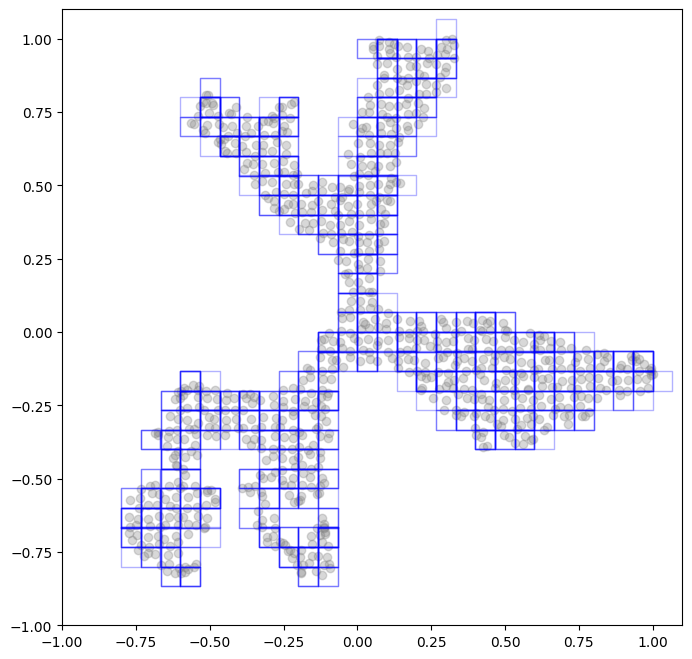

In [798]:
def discretize(coordinate, xmin, xmax, steps):
    '''
    '''
    grid_size = np.array(xmax) - np.array(xmin)
    grid_size = grid_size / np.array(steps)

    grid_idx = np.int64(np.floor((coordinate-xmin)/grid_size))
    grid_coor = xmin + grid_size * (grid_idx+0.5)
    return grid_idx, grid_coor 

def generate_grid(cell_embedding, velocity_embedding, steps):  
    cell_grid, grid_coor = discretize(cell_embedding, xmin=(-1,-1), xmax=(1,1), steps=steps)
    mesh = np.zeros((steps[0]+1, steps[1]+1, 2))

    cnt = np.zeros((steps[0]+1, steps[1]+1))
    for index in range(cell_grid.shape[0]):
        #print(index)
        i,j = cell_grid[index]
        mesh[i,j] += velocity[index]
        cnt[i,j] += 1

        
    # velocity of the grid = average velocity of the cells in the grid
    for i in range(steps[0]):
        for j in range(steps[1]):
            if cnt[i,j] > 1:
                #print(cnt[i,j], "in cell ", i, j)
                mesh[i,j] /= cnt[i,j]
    
    
    #sanity check
    fig, ax = plt.subplots(figsize=(8, 8))

    plt.scatter(cell_embedding[:,0],cell_embedding[:,1], c='grey', alpha = 0.3)
    plt.scatter(grid_coor[:,0], grid_coor[:,1], marker='s', color='none', edgecolor='blue', s=200, alpha=0.3)
    plt.xlim([-1,1.1])
    plt.ylim([-1,1.1])
    plt.show()
    
    return mesh


vel_mesh = generate_grid(cell_embedding, velocity, steps=(30,30))

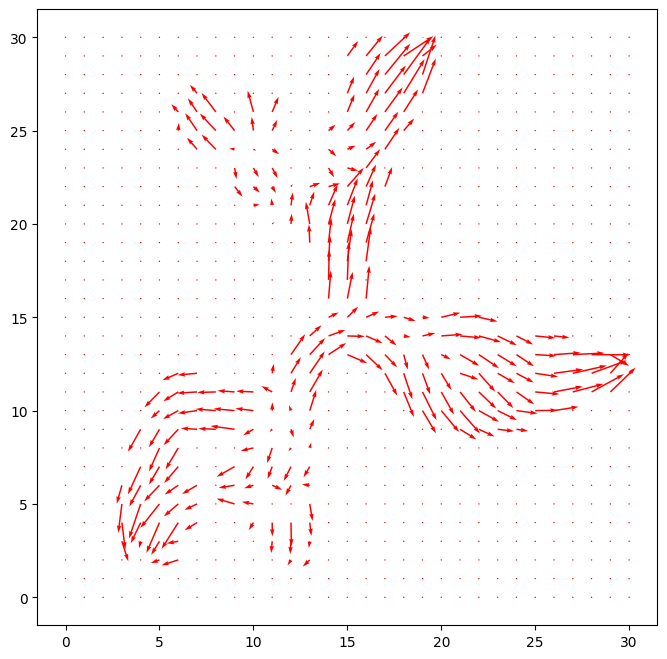

In [799]:
# sanity check
def plot_mesh_velocity(mesh):
    x=list()
    y=list()
    vx=list()
    vy=list()
    for i in range(mesh.shape[0]):
        for j in range(mesh.shape[1]):
            x.append(i)
            y.append(j)
            vx.append(mesh[i,j][0])
            vy.append(mesh[i,j][1])
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.quiver(x,y,vx,vy,color='red',scale = 15)

plot_mesh_velocity(vel_mesh)

In [800]:
def velocity_add_random(velocity, theta):
    '''
    Rotate the velocity according to a randomized kicks on the perpendicular direction.
    The direction is determined by the sign of a random number. 
    The magnitude of the perpendicular kick is determined by the random number 
    from a normal distribution N(0, theta).
    Magnitude of the velocity is kept the same to conserve energy (temperature) of the system.
    
    Parameters
    ----------
    velocity
        velocity of the grid
    theta
        the angular range that the noise could be affecting the direction of the velocity
        
    WARNING
        at a rare chance, the rotation angle (magnitude) could be much larger than theta.
        
    Return
    ------
    Adjusted velocity for the interested cell
        
    '''
    r = np.random.normal(0, theta, 1)
    cosine = np.cos(r)[0]
    sine = np.sin(r)[0]
    
    # Rotation matrix
    R = np.array([[cosine, sine],[-sine, cosine]])
    velocity = np.dot(velocity, R)
    return velocity

velocity_add_random(np.array([0,1]), np.pi/6)

array([-0.64208669,  0.76663204])

In [801]:
def velocity_rotation(velocity, theta):
    '''
    Rotate the velocity clockwise by angle theta
    
    Parameters
    ----------
    velocity
        velocity of the grid
    theta
        the angular range that the noise could be affecting the direction of the velocity
        
    Return
    ------
    Adjusted velocity for the interested cell
        
    '''
    cosine = np.cos(theta)
    sine = np.sin(theta)
    
    # Rotation matrix
    R = np.array([[cosine, sine],[-sine, cosine]])
    velocity = np.dot(velocity, R)
    return velocity

velocity_rotation(np.array([1,0]), np.pi/6)

array([0.8660254, 0.5      ])

3568


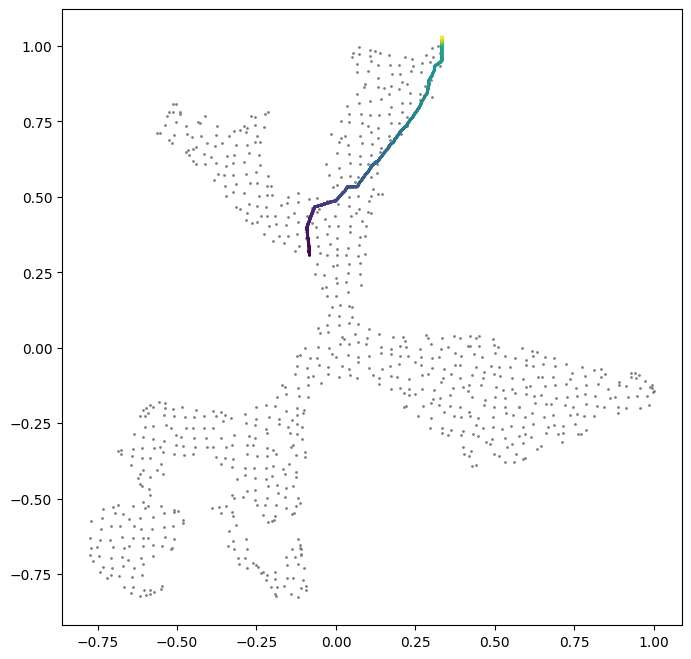

In [824]:
def diffusion_on_grid_wallbound(cell_embedding, vel, init, dt=0.001, t_total=10000, eps = 1e-5):
    
    '''
    Simulation of diffusion of a cell in the velocity field (on grid), the cell's velocity will turn 90 degrees
    if it hits the boundary the next timestep.
    
    Parameters
    ----------
    
    cell_embedding
        embedding coordinate for all the cells (downsampled)
    vel
        pre-assigned velocity of each grid
    init
        The initial position (cell_embedding)
    dt 
        Step size of each integration time step
    t_total
        Total number of time steps
    eps 
        Criterion to stop a trajectory before t_total (v_net < eps)
    
    Return
    ------
        a numpy array of coordinates in the trajectory,  shape: (real_n_time_steps, 2)
    '''
    
    #from collections import deque

    # TODO: recommmend values of dt and timestep
    THETA = np.pi/6
    
    #WANDER_LIMIT = 10
    XMIN=(-1,-1)
    XMAX=(1,1)
    STEPS=(vel.shape[0]-1,vel.shape[1]-1)
    
    x0 = init
    x0_d, dummy = discretize(x0, xmin=XMIN, xmax=XMAX, steps=STEPS)
    v0 = vel[x0_d[0],x0_d[1]]
    v0 = velocity_add_random(v0, THETA)
    trajectory = [x0]
    
    #TODO: limit wandering trajectories.
    #wander = deque(np.random.rand(WANDER_LIMIT,2)) 
    
    #wander = 0
    # trivial cases starting from a destination.
    if np.linalg.norm(v0) < eps:
        #print("initial velocity is too small")
        return trajectory
    
    for i in range(t_total):
        x = x0 + v0*dt
        x_d, dummy = discretize(x, xmin=XMIN, xmax=XMAX, steps=STEPS)
       # wander.append(x_d)

        # TODO:
        #if np.allclose(np.std(wander),0):
            #print(wander)
        #    del trajectory[-(WANDER_LIMIT-1):]
        #    break
        
        try:
            v = vel[x_d[0],x_d[1]]
            v = velocity_add_random(v, THETA)
        except IndexError:
            if np.any(np.abs(x_d-x0_d)>3):
                print("From ", x0_d, "to ", x_d, "in one step.")
                print("Error: dt too large! Decrease dt and restart!")
            break
            
        # check if the cell is on an empty grid; 
        # if so, stay at the current grid, and 
        # turn the velocity 90 degrees clockwise. 
        if np.linalg.norm(v) == 0:
            #wander += 1
            #if wander == 10:
            #    break
            v0 = velocity_rotation(v0, np.pi/2)
        elif np.linalg.norm(v) < eps:
            break
        else:
            trajectory.append(x)
            x0 = x
            v0 = v

    return np.array(trajectory)

traj=diffusion_on_grid_wallbound(cell_embedding, vel_mesh, cell_embedding[10], 0.001, 5000)
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(cell_embedding[:,0], cell_embedding[:,1], c='gray', s=1)
plt.scatter(traj[:,0], traj[:,1], s=1, c=range(len(traj)))
print(len(traj))

In [88]:
def diffusion_on_grid0(cell_embedding, vel, init, dt=0.01, timestep=10000):
    '''
    # no random velocity
    # no off-cell position 
    '''
    
    # TODO: recommmend values of dt and timestep
    x0 = cell_embedding[init]
    x0_d = discretize(x0)
    v0 = vel[x0_d[0],x0_d[1]]
    trajectory = [x0]
    
    # trivial cases starting from a destination.
    if np.linalg.norm(v0) < 1e-5:
        return trajectory
    
    for i in range(timestep):
        x = x0 + v0*dt
        x_d = discretize(x)
        try:
            v = vel[x_d[0],x_d[1]]
        except IndexError:
            break
        
        if np.linalg.norm(v) < 1e-5:
            break
        trajectory.append(x)
        x0 = x
        v0 = v

    return np.array(trajectory)

In [90]:
def diffusion_on_grid(cell_embedding, vel, init, dt=0.1, t_total=10000, eps = 1e-5):
    
    '''
    Simulation of diffusion of a cell in the velocity field (on grid)
    
    Parameters
    ----------
    
    cell_embedding
        embedding coordinate for all the cells (downsampled)
    vel
        pre-assigned velocity of each grid
    init
        The initial position (cell_embedding)
    dt 
        Step size of each integration time step
    t_total
        Total number of time steps
    eps 
        Criterion to stop a trajectory before t_total (v_net < eps)
    
    Return
    ------
        a numpy array of coordinates in the trajectory,  shape: (real_n_time_steps, 2)
    '''
    
    
    # TODO: recommmend values of dt and timestep
    theta = np.pi/6
    x0 = init
    x0_d, dummy = discretize(x0, xmin=(-1,-1), xmax=(1,1), steps=(30,30))
    v0 = vel[x0_d[0],x0_d[1]]
    v0 = velocity_add_random(v0, theta)
    trajectory = [x0]
    
    # trivial cases starting from a destination.
    if np.linalg.norm(v0) < eps:
        #print("initial velocity is too small")
        return trajectory
    
    for i in range(t_total):
        x = x0 + v0*dt
        x_d, dummy = discretize(x, xmin=(-1,-1), xmax=(1,1), steps=(30,30))
        try:
            v = vel[x_d[0],x_d[1]]
            v = velocity_add_random(v, theta)
        except IndexError:
            #print("out of boundary")
            break
        
        if np.linalg.norm(v) < eps:
            #print("velocity is too small")
            break
        trajectory.append(x)
        x0 = x
        v0 = v
    
    return np.array(trajectory)
    
#diffusion_on_grid(cell_embedding, vel_mesh, cell_embedding[1], 0.05, 1000)

In [91]:
def diffusion_on_grid2(cell_embedding, vel, init, dt, timestep):
    
    '''
    transfer out of boundary cells to the nearest neighbour grid.
    '''
    
    x0 = cell_embedding[init]
    x0_d = discretize(x0)
    v0 = vel[x0_d[0],x0_d[1]]
    trajectory = [x0]
    
    # trivial cases starting from a destination.
    if np.linalg.norm(v0) < 1e-5:
        return trajectory
    
    for i in range(timestep):
        x = x0 + v0*dt
        x_d = discretize(x)
        try:
            v = vel[x_d[0],x_d[1]]
        except IndexError:
            break
        
        if np.linalg.norm(v) < 1e-5:
        # consider whether a near grid has velocity
            x0_d = discretize(x0)
            x_1 = np.array([x0[0], x[1]])
            x_2 = np.array([x[0], x0[1]])
            
            v_1 = vel[x0_d[0], x_d[1]]
            v_2 = vel[x_d[0], x0_d[1]]
            
            if np.linalg.norm(v_1)+np.linalg.norm(v_2) < 1e-5:
                trajectory.append(x)
                break
            else:
                x, v = (x_1,v_1) if np.linalg.norm(v_1) > np.linalg.norm(v_2) else (x_2,v_2)
                
        trajectory.append(x)
        x0 = x
        v0 = v

    return np.array(trajectory)

In [804]:
def compute_trajectory_displacement(traj):
    traj = np.array(traj)
    return np.linalg.norm(traj[-1,:] - traj[0,:])

In [805]:
def compute_trajectory_length(traj1):
    temp = traj1[:-1,:] - traj1[1:,:]
    length = np.sum(np.sqrt(np.sum(temp**2, axis=1)))
    return length

def compute_trajectory_similarity(traj1, traj2, numPicks=10):
    '''
    Computes the similarity between two curves based on average distance of a selection of closest pairs

    Input: 
    - numpy arrays (nsteps1, 2), (nsteps2, 2); nsteps1 >= nsteps2 
    - numPicks: number of representative points on the shorter curve traj2
    Return: a float number
    '''
    # assert traj1 longer than traj2
    # empty traj2
    if not traj2.size:
        print("empty trajectory here!")
        raise 
    # pick N points evenly from traj2
    idx = np.round(np.linspace(0, len(traj2) - 1, numPicks)).astype(int)
    
    # in the case the shorter trajectory is less than numPicks timesteps
    idx = np.unique(idx)
    
    temp = traj1 - traj2[idx, None]
    A = np.min(np.sum(temp**2, axis=2), axis=1)
    
    return np.mean(A**(1/2))

In [806]:
def compute_similarity_matrix(traj, numPicks=10):
    import itertools
    traj_length = np.array([compute_trajectory_length(np.array(i)) for i in traj])
    traj_order = np.argsort(traj_length) # 1d array
    
    ncells = len(traj_order)
    simMat = np.zeros((ncells,ncells))
    for i,j in itertools.combinations(traj_order, 2):
            # length of traj[i] <= traj[j]
            simMat[i,j] = compute_trajectory_similarity(np.array(traj[j]), np.array(traj[i]), numPicks)
            simMat[j,i] = simMat[i,j]
    return simMat


In [825]:
def run_diffusion(cell_embedding, vel, dt, t_total = 10000, eps = 1e-5, 
                  off_cell_init = False, n_repeats = 10, n_jobs = 8):    
    '''
    Simulation of diffusion of a cell in the velocity field (on grid), 
    the cell's velocity will turn 90 degrees if it hits the boundary the next timestep.
    Embarrassingly parallel (process) are employed.
    
    Parameters
    ----------
    
    cell_embedding: numpy.ndarray (ncells, 2)
        embedding coordinate for all the cells (downsampled)
        
    vel: numpy.ndarray (ngrid, ngrid, 2)
        pre-assigned velocity of each grid
    
    dt: float
        Step size of each integration time step
    
    t_total: int
        Total number of time steps
    
    eps: float
        Criterion to stop a trajectory before t_total (v_net < eps)
    
    off_cell_init: Boolean
        Whether to spawn initial coordinates from the neighbouring space around a cell
    
    n_repeats: init
        Number of repeats (either on or off the cells)
    
    n_jobs: int
        Number of threads
    
    Return
    ------
        a numpy array of trajectorys,  shape: (num_trajs, *n_time_steps, 2)
    '''
        
    if n_jobs >= mp.cpu_count():
        n_jobs = max(8, mp.cpu_count()-1)
        print("Reducing n_jobs to", n_jobs, "for optimal performance.")

    TASKS = list()
    # Setting up the TASKS
    n_cells = cell_embedding.shape[0]
    # We always normalize the embedding to [-1:1, -1:1]
    embedding_range = np.array([2,2])
    steps = np.array([vel.shape[0], vel.shape[1]])
    grid_size = embedding_range/steps
    
    for i in range(n_cells):
        for j in range(n_repeats):
            if off_cell_init:
                init_position = cell_embedding[i] + grid_size * np.random.uniform(-0.5,0.5,2)
            else:
                init_position = cell_embedding[i]
            TASKS.append((cell_embedding, vel_mesh, init_position, dt, t_total))
    
    with mp.Pool(n_jobs) as pool:
        paths = pool.starmap(diffusion_on_grid_wallbound, TASKS)
    return np.array(paths)


import time
start_time = time.time()
paths = run_diffusion(cell_embedding, vel_mesh, 0.001, 5000, 
                      1e-5, False, n_repeats = 10, n_jobs = mp.cpu_count()-1) 
print("--- %s seconds ---" % (time.time() - start_time))

--- 314.4942009449005 seconds ---


In [809]:
%%script echo skipping
def run_diffusion_joblib(cell_embedding, vel, dt, t_toal = 10000, eps = 1e-5, 
                  off_cell_init = False, n_repeats = 10, n_jobs = 8):    
    '''
    Simulation of diffusion of a cell in the velocity field (on grid), 
    the cell's velocity will turn 90 degrees if it hits the boundary the next timestep.
    
    Parameters
    ----------
    
    cell_embedding: numpy.ndarray (ncells, 2)
        embedding coordinate for all the cells (downsampled)
        
    vel: numpy.ndarray (ngrid, ngrid, 2)
        pre-assigned velocity of each grid
    
    dt: float
        Step size of each integration time step
    
    t_total: int
        Total number of time steps
    
    eps: float
        Criterion to stop a trajectory before t_total (v_net < eps)
    
    off_cell_init: Boolean
        Whether to spawn initial coordinates from the neighbouring space around a cell
    
    n_repeats: init
        Number of repeats (either on or off the cells)
    
    n_jobs: int
        Number of threads
    
    Return
    ------
        a numpy array of trajectorys,  shape: (num_trajs, *n_time_steps, 2)
    '''
    
    from joblib import Parallel, delayed, parallel_backend
    
    TASKS = list()
    # Setting up the TASKS
    n_cells = cell_embedding.shape[0]
    # We always normalize the embedding to [-1:1, -1:1]
    embedding_range = np.array([2,2])
    steps = np.array([vel.shape[0]-1, vel.shape[1]-1])
    grid_size = embedding_range/steps
    
    
    def producer():
        for i in range(ncells):
            for j in range(n_repeats):
                if off_cell_init:
                    init_position = cell_embedding[i] + grid_size * np.random.uniform(-0.5,0.5,2)
                else:
                    init_position = cell_embedding[i]
                yield (cell_embedding, vel_mesh, init_position, 0.001, 10000)
    
    #paths=Parallel(n_jobs=n_jobs, pre_dispatch='1.5*n_jobs', b="", require='sharedmem')(
    #            delayed(diffusion_on_grid_wallbound)(*i) for i in producer())
    with parallel_backend("multiprocessing", inner_max_num_threads=4):
        paths = Parallel(n_jobs=n_jobs)(delayed(diffusion_on_grid_wallbound)(*i) for i in producer())
    return np.array(paths)

skipping


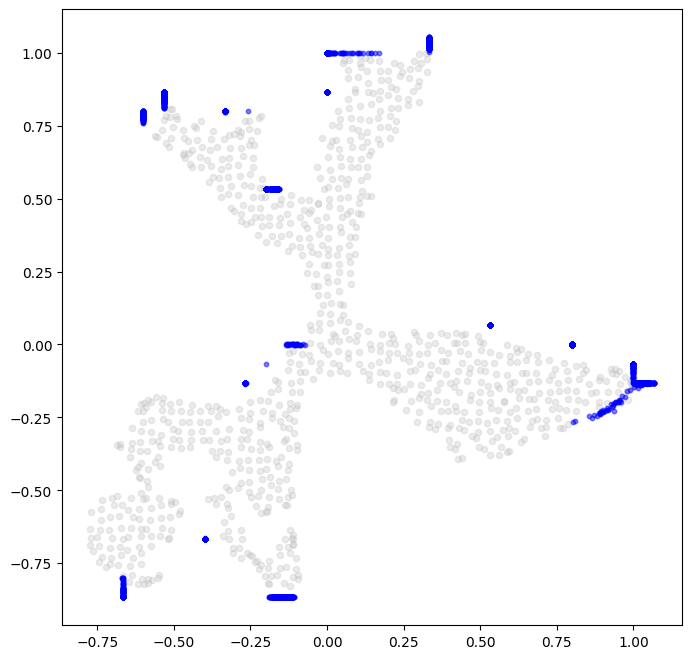

the longest trajectory measures:  1.2933629446200563


In [833]:
def Plot_end_state(paths):
    # sanity check; end points of all the trajectories
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.scatter(cell_embedding[:,0], cell_embedding[:,1], c='silver', s=20, alpha=0.3)
    endState = np.array([(i[-1,0], i[-1,1]) for i in paths])
    plt.scatter(endState[:,0], endState[:,1], s=10, c='blue', alpha=0.5)
    #plt.scatter(grid_coor[:,0], grid_coor[:,1], marker='s', color='none', edgecolor='blue', s=200, alpha=0.1)

    plt.show()
Plot_end_state(paths)

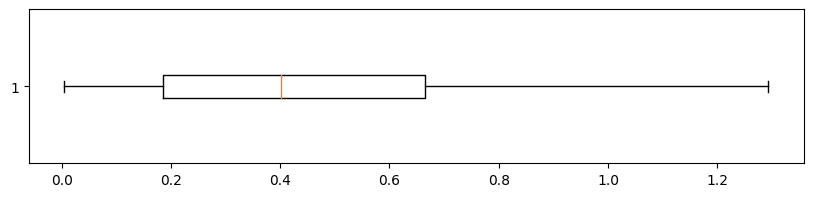

In [837]:
traj_displacement = np.array([compute_trajectory_displacement(ipath) for ipath in paths])
fig, ax = plt.subplots(figsize=(10,2))
plt.boxplot(traj_displacement,vert=False)
plt.show()

In [23]:
%%script echo skipping
traj2 = list()
for i in range(891):
    traj2.append(diffusion_on_grid2(embedding_downsampling.to_numpy(),vel_mesh, i, 0.005, 5000))

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c='gray', s=1)

for i in traj2:
    plt.scatter(np.array(i)[:,0], np.array(i)[:,1], s=1, c=range(len(i)))
    ax.set_aspect('equal', adjustable='box')

plt.show()

skipping


In [24]:
%%script echo skipping
fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c='gray', s=1)

for i in traj2:
    plt.scatter(np.array(i)[-1,0], np.array(i)[-1:,1], s=5, c='red')
    ax.set_aspect('equal', adjustable='box')

plt.show()

skipping


In [27]:
%%script echo skipping
# vel_mesh interpolation/extrapolation.

x = np.arange(0,steps[0]+1,1)
y = np.arange(0,steps[1]+1,1)
X, Y = np.meshgrid(x,y)

sx = list()
sy = list()
vx = list()
vy = list()

for i in range(vel_mesh.shape[0]):
    for j in range(vel_mesh.shape[1]):
        if np.linalg.norm(vel_mesh[i,j]) > 0:
            sx.append(i)
            sy.append(j)
            vx.append(vel_mesh[i,j][0])
            vy.append(vel_mesh[i,j][1])
points = np.transpose(np.vstack((sx, sy)))

vx_interp = interpolate.griddata(points, vx, (X, Y), method='linear')
vy_interp = interpolate.griddata(points, vy, (X, Y), method='linear')

for i in range(vel_mesh.shape[0]):
    for j in range(vel_mesh.shape[1]):
        vel_mesh[i,j]=np.array([vx_interp[i,j],vy_interp[i,j]])

skipping


In [26]:
%%script echo skipping
plt.figure(1)
plt.quiver(sx, sy, vx, vy)
plt.figure(2)
plt.quiver(X, Y, vx_interp, vy_interp)
plt.show()

skipping


In [838]:
%%script echo skipping
def hierarchical_clustering(paths, similarity_matrix, n_clusters):

    flat_dist_mat = squareform(similarity_matrix)
    sim_linkage = linkage(flat_dist_mat, method='ward', preserve_input=False)

    plt.rcParams['figure.figsize']=(10,15)
    dn = dendrogram(sim_linkage, 
                    orientation='left',
                    no_labels=True,
                   show_leaf_counts=True)
    plt.rcdefaults()
    plt.show
    return sim_linkage

similarity_matrix_10 = compute_similarity_matrix(paths, numPicks=10)
sim_linkage = hierarchical_clustering(paths, similarity_matrix_10, 6)

skipping


In [839]:
%%script echo skipping
nclusters = 5
num_traj_threshold = 1
traj_cluster = list()

cluster_label = fcluster(sim_linkage, t=nclusters, criterion='maxclust')
clusters = list()
for i in range(nclusters):
    traj_cluster = paths[np.where(cluster_label == i+1)]
    clusters.append(traj_cluster[:10])
    #plot_trajs(embedding_downsampling, traj_cluster, i+1)
vis_path_clusters(embedding_downsampling, clusters, nclusters)

skipping


In [840]:
def clustering(path_clusters, cell_clusters, paths, traj_length, similarity_threshold, nkeep=10):
    '''
    a clustering method to find representative paths.
    
    Parameters
    ----------
    
    paths: np.ndarray (N, ntimesteps, 2)
        N paths, sorted by their |displacement|, each trajectory is a (ntimestep, 2) array
        
    traj_length: list 
        |displacement| of the trajectories (N, )
        
    similarity_threshold: float
        first round clustering to keep trajectories which are within this threshold
    
    After each iteration, a number of trajectories are popped in the traj list as well as the traj_length list.
    returns a list of clusters
    
    Return
    ------
    a list of np.ndarray (ntimesteps, 2)
    
    '''
    print("There are ", len(path_clusters), "clusters.\t", len(paths), "paths to be categorized")
    if not paths.size:
        return path_clusters, cell_clusters
    
    longest = paths[0]
    #print(traj_length)
    similarity = np.array([compute_trajectory_similarity(np.array(longest), np.array(ipath), 10) 
                           for ipath in paths])
    sel = similarity < similarity_threshold
    path_clusters.append(paths[sel][:nkeep])
    cell_clusters.append([ipath[0] for ipath in paths[sel]])
    
    paths = paths[~sel]
    traj_length = traj_length[~sel]
    return clustering(path_clusters, cell_clusters, paths, traj_length, similarity_threshold, nkeep)

In [841]:
traj_displacement = np.array([compute_trajectory_displacement(ipath) for ipath in paths])
order = np.argsort(traj_displacement)[::-1]
sorted_traj = paths[order]
traj_displacement=traj_displacement[order]

In [842]:
path_clusters = list()
cell_clusters = list()
path_clusters, cell_clusters = clustering(
    path_clusters, cell_clusters, 
    sorted_traj, traj_displacement, 
    0.4, nkeep=10)

There are  0 clusters.	 8880 paths to be categorized
There are  1 clusters.	 6153 paths to be categorized
There are  2 clusters.	 3184 paths to be categorized
There are  3 clusters.	 1200 paths to be categorized
There are  4 clusters.	 560 paths to be categorized
There are  5 clusters.	 0 paths to be categorized


In [858]:
def cellPath(cell_embedding, cell_clusters):
    '''
    Parameters
    ----------
    cell_embedding: numpy ndarray (ncells, 2)
    
    cell_clusters: List lenth: n_clusters
        A list of starting cell positions (1,2) in each cluster.
        
    Return
    ------
    A numpy array (ncells, n_clusters) recording number of occurence in each path 
    '''
    
    n_clusters = len(cell_clusters)
    n_cells = len(cell_embedding)

    # initialization
    # each cell has a chance to go through the n_clusters fates
    # defined by [p0, p1, ..., p{n_cluster-1}]
    cell_fate = np.zeros((n_cells, n_clusters))
    cluster_index = 0
    for icluster in cell_clusters:
        temp = icluster - cell_embedding[:,None]
        # tuple [0] --> cell indices
        # tuple [1] --> traj indices in the cluster
        for i in np.where(np.sum(temp**2, axis = 2) == 0)[0]:
            cell_fate[i][cluster_index] += 1
        cluster_index += 1
    return cell_fate

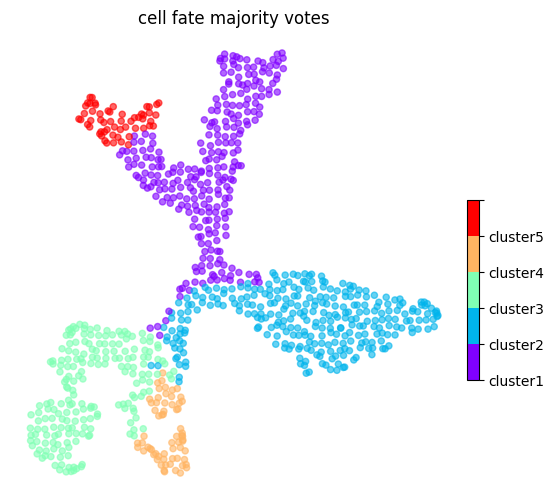

In [977]:
def Plot_cell_cluster(cell_embedding, cell_clusters):
    cmap = cm.get_cmap('rainbow', len(cell_clusters)) 
    cell_fate = cellPath(cell_embedding, cell_clusters)
    cell_fate_majority = cell_fate.argmax(axis=1)
    fig, ax1 = plt.subplots(figsize=(6, 6))
    img1=ax1.scatter(cell_embedding[:,0], cell_embedding[:,1], c=cell_fate_majority, s=20, alpha=0.6, cmap=cmap)
    ax1.set_aspect('equal', adjustable='box')
    ax1.set_title("cell fate majority votes")
    ax1.axis("off")

    bounds = np.linspace(0, len(cell_clusters), len(cell_clusters)+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    ax3 = fig.add_axes([0.9, 0.3, 0.02, 0.3])
    cb = mpl.colorbar.ColorbarBase(ax3, cmap=cmap, spacing='proportional', boundaries=bounds, norm=norm, format='%1i')
    cb.set_ticklabels(["cluster1", "cluster2", "cluster3", "cluster4", "cluster5", ""])
    
    #fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,6))
    #cbar1=fig.colorbar(img1, ax=ax1)
    #cbar1.set_label("cluster number")
    #img2=ax2.scatter(cell_embedding[:,0], cell_embedding[:,1], c=cell_fate.max(axis=1), s=20, alpha=0.6, cmap=plt.cm.tab20c)
    #cbar2 = fig.colorbar(img2, ax=ax2)
    #cbar2.ax.get_yaxis().set_ticks([])
    #cbar2.set_label('# of most probable path per 10 runs', rotation=90)
    #ax2.set_aspect('equal', adjustable='box')
    #ax2.set_title("multi-fate cells")
    #ax2.axis("off")

    plt.show()
Plot_cell_cluster(cell_embedding, cell_clusters)

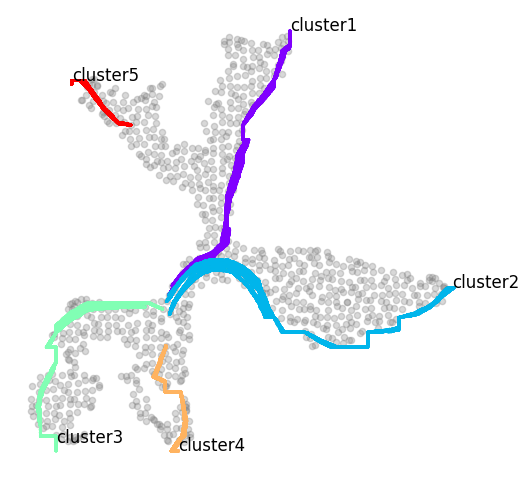

In [986]:
def Plot_path_clusters(cell_embedding, clusters, n_clusters):
    from matplotlib.pyplot import cm
    
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.scatter(cell_embedding[:,0], cell_embedding[:,1], c='gray', s=20, alpha = 0.3)
    
    colors = iter(cm.rainbow(np.linspace(0, 1, n_clusters)))
    cluster_cnt = 0
    for cluster in clusters[:n_clusters]:
        cluster_cnt += 1
        cl = next(colors)
        plt.text(cluster[0][-1,0], cluster[0][-1,1], "cluster"+str(cluster_cnt), fontsize=12)
        for ipath in cluster:
            c = np.repeat(cl[None,:],len(ipath), axis=0)
            plt.scatter(np.array(ipath)[:,0], np.array(ipath)[:,1], s=1, c=c)
    plt.axis('off')
    plt.show()
    
Plot_path_clusters(cell_embedding, path_clusters, n_clusters=5)

In [886]:
%%script echo skipping 
new_path = np.array([path for cluster in clusters for path in cluster])
nclusters = 7
new_sim = compute_similarity_matrix(new_path, numPicks=10)
new_sim_linkage = hierarchical_clustering(new_path, new_sim, nclusters)

new_cluster_label = fcluster(new_sim_linkage, t=nclusters, criterion='maxclust')
for i in range(nclusters):
    traj_cluster = new_path[np.where(new_cluster_label == i+1)]
    #clusters.append(traj_cluster[:10])
    #plot_trajs(embedding_downsampling, traj_cluster, i+1)
vis_path_clusters(cell_embedding, clusters, nclusters)

skipping


In [989]:
def Cell_time_assignment(embedding, rep_paths, cell_fate):
    longest_paths = [ipath[0] for ipath in rep_paths]
    cell_time_per_cluster = list()
    for i in range(len(rep_paths)):
        print("Path ", i+1)
        cells = cell_embedding[cell_fate == i]
        cell_index = np.where(cell_fate == i)[0]
        dist = cells[:,None] - longest_paths[i]
        cell_time=np.argmin(np.sum(dist**2, axis = 2), axis = 1)
        cell_time_per_cluster.append({A: B for A, B in zip(cell_index, cell_time)})
    return cell_time_per_cluster

cell_fate = cellPath(cell_embedding, cell_clusters)
cell_fate_major = np.argmax(cell_fate, axis=1)
cell_time_per_cluster = Cell_time_assignment(cell_embedding, path_clusters, cell_fate_major)


Path  1
Path  2
Path  3
Path  4
Path  5


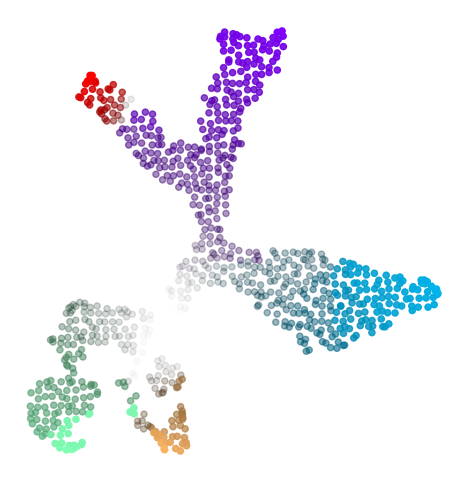

In [991]:
def Plot_celltime_clusters(cell_time_per_cluster, embedding): 
    fig, ax = plt.subplots(figsize=(6, 6))

    cmap = cm.get_cmap('rainbow', 5) 
    n_paths = len(longest_paths)

    for i in range(n_paths):
        # create colormap for each path
        colormap = ListedColormap(np.linspace(0, cmap(i), 256))
        cell_index = list(cell_time_per_cluster[i].keys())
        cell_time = list(cell_time_per_cluster[i].values())
        cells = embedding[cell_index]
        #pos = np.mean(cells, axis=0)
        plt.scatter(cells[:,0], cells[:,1], c=cell_time, s=20, cmap = colormap)
        #plt.text(pos[0], pos[1], "cluster"+str(i+1), fontsize=12)
        ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.show()
Plot_celltime_clusters(cell_time_per_cluster, cell_embedding)

In [ ]:
Fit_time_for_all_cells()
# vel_mesh interpolation/extrapolation.

x = np.arange(0,steps[0]+1,1)
y = np.arange(0,steps[1]+1,1)
X, Y = np.meshgrid(x,y)

sx = list()
sy = list()
vx = list()
vy = list()

for i in range(vel_mesh.shape[0]):
    for j in range(vel_mesh.shape[1]):
        if np.linalg.norm(vel_mesh[i,j]) > 0:
            sx.append(i)
            sy.append(j)
            vx.append(vel_mesh[i,j][0])
            vy.append(vel_mesh[i,j][1])
points = np.transpose(np.vstack((sx, sy)))

vx_interp = interpolate.griddata(points, vx, (X, Y), method='linear')
vy_interp = interpolate.griddata(points, vy, (X, Y), method='linear')

